# CDISC by Vanessa Pitz

In [24]:
# Install dependencies
install.packages("remotes")
install.packages("dplyr")
install.packages("sdtm.oak")
install.packages("lubridate")
install.packages("admiral")
install.packages("admiral.test")
install.packages("ggplot2")

# Install pharmaverse packages
remotes::install_github("pharmaverse/admiral")       # ADaM
remotes::install_github("pharmaverse/pharmaversesdtm") # Example SDTM datasets

# Load them
library(dplyr)
library(lubridate)
library(admiral)       
library(admiral.test)
library(ggplot2)



The downloaded binary packages are in
	/var/folders/y0/lv_642997xxc8l_f86kcsh6h0000gn/T//RtmppZRcgO/downloaded_packages

The downloaded binary packages are in
	/var/folders/y0/lv_642997xxc8l_f86kcsh6h0000gn/T//RtmppZRcgO/downloaded_packages

The downloaded binary packages are in
	/var/folders/y0/lv_642997xxc8l_f86kcsh6h0000gn/T//RtmppZRcgO/downloaded_packages

The downloaded binary packages are in
	/var/folders/y0/lv_642997xxc8l_f86kcsh6h0000gn/T//RtmppZRcgO/downloaded_packages

The downloaded binary packages are in
	/var/folders/y0/lv_642997xxc8l_f86kcsh6h0000gn/T//RtmppZRcgO/downloaded_packages

The downloaded binary packages are in
	/var/folders/y0/lv_642997xxc8l_f86kcsh6h0000gn/T//RtmppZRcgO/downloaded_packages

The downloaded binary packages are in
	/var/folders/y0/lv_642997xxc8l_f86kcsh6h0000gn/T//RtmppZRcgO/downloaded_packages



-- R CMD build -----------------------------------------------------------------
* checking for file '/private/var/folders/y0/lv_642997xxc8l_f86kcsh6h0000gn/T/RtmppZRcgO/remotes17fd63b6c7e6c/pharmaverse-admiral-99d1079/DESCRIPTION' ... OK
* preparing 'admiral':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building 'admiral_1.3.1.9008.tar.gz'



Skipping install of 'pharmaversesdtm' from a github remote, the SHA1 (eebc9b86) has not changed since last install.
  Use `force = TRUE` to force installation



In [25]:
# Example Raw Data

raw_data = tibble(
  subject_id = c("01", "02", "03"),
  visit_date = as.Date(c("2025-01-01", "2025-01-01", "2025-01-02")),
  age = c(45, 60, 37),
  gender = c("M", "F", "M"),
  systolic = c(120, 135, 128),
  diastolic = c(80, 85, 78),
  adverse_event = c("Headache", NA, "Nausea"),
  ae_severity = c("Mild", NA, "Moderate"))

head(raw_data)

subject_id,visit_date,age,gender,systolic,diastolic,adverse_event,ae_severity
<chr>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
01,2025-01-01,45,M,120,80,Headache,Mild
02,2025-01-01,60,F,135,85,NA,NA
03,2025-01-02,37,M,128,78,Nausea,Moderate


In [26]:
# Build SDTM data

sdtm_dm = raw_data %>%
  select(subject_id, age, gender) %>%
  rename(USUBJID = subject_id,
    AGE = age,
    SEX = gender)

head(sdtm_dm)

sdtm_vs = raw_data %>%
  select(subject_id, visit_date, systolic, diastolic) %>%
  rename(USUBJID = subject_id,
    VISITDY = visit_date,
    SBP = systolic,
    DBP = diastolic)

head(sdtm_vs)

sdtm_ae = raw_data %>%
  filter(!is.na(adverse_event)) %>%
  select(subject_id, adverse_event, ae_severity) %>%
  rename( USUBJID = subject_id,
      AETERM = adverse_event,
      AESEV = ae_severity)
head(sdtm_ae)

USUBJID,AGE,SEX
<chr>,<dbl>,<chr>
01,45,M
02,60,F
03,37,M


USUBJID,VISITDY,SBP,DBP
<chr>,<date>,<dbl>,<dbl>
01,2025-01-01,120,80
02,2025-01-01,135,85
03,2025-01-02,128,78


USUBJID,AETERM,AESEV
<chr>,<chr>,<chr>
01,Headache,Mild
03,Nausea,Moderate


In [27]:
# Example ADaM

## subject-level example
adsl = sdtm_dm %>%
mutate( TRTSDT = as.Date("2025-01-01"),  # treatment start
        TRTEDT = as.Date("2025-01-10"))  # treatment end

head(adsl)

## vital signs example BDS
adam_vs = sdtm_vs %>% 
mutate( PARAM = "Blood Pressure",
        PARAMCD = "BP",
        AVISIT = "Baseline",
        CHG = SBP - 120)   # Example: difference from 120

head(adam_vs)

USUBJID,AGE,SEX,TRTSDT,TRTEDT
<chr>,<dbl>,<chr>,<date>,<date>
01,45,M,2025-01-01,2025-01-10
02,60,F,2025-01-01,2025-01-10
03,37,M,2025-01-01,2025-01-10


USUBJID,VISITDY,SBP,DBP,PARAM,PARAMCD,AVISIT,CHG
<chr>,<date>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
01,2025-01-01,120,80,Blood Pressure,BP,Baseline,0
02,2025-01-01,135,85,Blood Pressure,BP,Baseline,15
03,2025-01-02,128,78,Blood Pressure,BP,Baseline,8


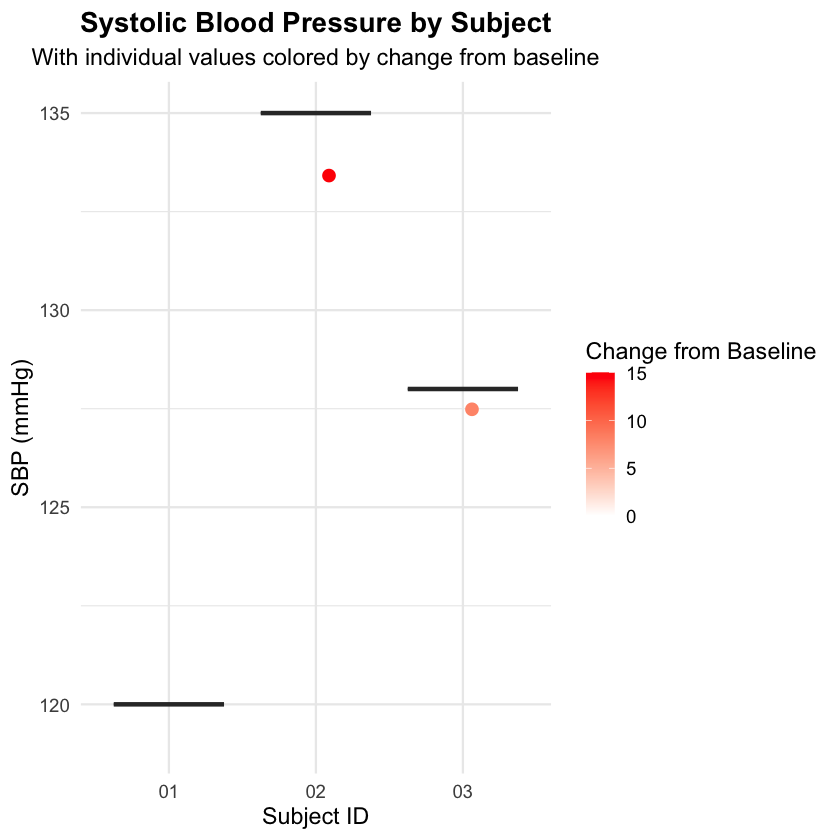

In [28]:
# visualizations - not enough data points..
ggplot(adam_vs, aes(x = USUBJID, y = SBP)) +
  geom_boxplot(fill = "lightblue", outlier.color = "red", outlier.shape = 16) +
  geom_jitter(aes(color = CHG), width = 0.1, size = 3) +  # einzelne Werte
  scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  labs(title = "Systolic Blood Pressure by Subject",
    subtitle = "With individual values colored by change from baseline",
    x = "Subject ID",
    y = "SBP (mmHg)",
    color = "Change from Baseline") +
  theme_minimal(base_size = 14) +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5))


In [29]:
table_vs = adam_vs %>%
  summarise(
    N = n(),
    SBP_Mean = round(mean(SBP, na.rm = TRUE), 1),
    SBP_SD   = round(sd(SBP, na.rm = TRUE), 1),
    DBP_Mean = round(mean(DBP, na.rm = TRUE), 1),
    DBP_SD   = round(sd(DBP, na.rm = TRUE), 1),
    CHG_Mean = round(mean(CHG, na.rm = TRUE), 1)
  )

table_vs

N,SBP_Mean,SBP_SD,DBP_Mean,DBP_SD,CHG_Mean
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,127.7,7.5,81,3.6,7.7


In [ ]:
# Load example SDTM DM (Demographics) dataset
dm = pharmaversesdtm::dm
head(dm)

# Load example SDTM AE (Adverse Events) dataset
ae = pharmaversesdtm::ae
head(ae)


STUDYID,DOMAIN,USUBJID,SUBJID,RFSTDTC,RFENDTC,RFXSTDTC,RFXENDTC,RFICDTC,RFPENDTC,...,SEX,RACE,ETHNIC,ARMCD,ARM,ACTARMCD,ACTARM,COUNTRY,DMDTC,DMDY
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
CDISCPILOT01,DM,01-701-1015,1015,2014-01-02,2014-07-02,2014-01-02,2014-07-02,NA,2014-07-02T11:45,...,F,WHITE,HISPANIC OR LATINO,Pbo,Placebo,Pbo,Placebo,USA,2013-12-26,-7
CDISCPILOT01,DM,01-701-1023,1023,2012-08-05,2012-09-02,2012-08-05,2012-09-01,NA,2013-02-18,...,M,WHITE,HISPANIC OR LATINO,Pbo,Placebo,Pbo,Placebo,USA,2012-07-22,-14
CDISCPILOT01,DM,01-701-1028,1028,2013-07-19,2014-01-14,2013-07-19,2014-01-14,NA,2014-01-14T11:10,...,M,WHITE,NOT HISPANIC OR LATINO,Xan_Hi,Xanomeline High Dose,Xan_Hi,Xanomeline High Dose,USA,2013-07-11,-8
CDISCPILOT01,DM,01-701-1033,1033,2014-03-18,2014-04-14,2014-03-18,2014-03-31,NA,2014-09-15,...,M,WHITE,NOT HISPANIC OR LATINO,Xan_Lo,Xanomeline Low Dose,Xan_Lo,Xanomeline Low Dose,USA,2014-03-10,-8
CDISCPILOT01,DM,01-701-1034,1034,2014-07-01,2014-12-30,2014-07-01,2014-12-30,NA,2014-12-30T09:50,...,F,WHITE,NOT HISPANIC OR LATINO,Xan_Hi,Xanomeline High Dose,Xan_Hi,Xanomeline High Dose,USA,2014-06-24,-7
CDISCPILOT01,DM,01-701-1047,1047,2013-02-12,2013-03-29,2013-02-12,2013-03-09,NA,2013-07-28,...,F,WHITE,NOT HISPANIC OR LATINO,Pbo,Placebo,Pbo,Placebo,USA,2013-01-22,-21


STUDYID,DOMAIN,USUBJID,AESEQ,AESPID,AETERM,AELLT,AELLTCD,AEDECOD,AEPTCD,...,AESDISAB,AESDTH,AESHOSP,AESLIFE,AESOD,AEDTC,AESTDTC,AEENDTC,AESTDY,AEENDY
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
CDISCPILOT01,AE,01-701-1015,1,E07,APPLICATION SITE ERYTHEMA,APPLICATION SITE REDNESS,NA,APPLICATION SITE ERYTHEMA,NA,...,N,N,N,N,N,2014-01-16,2014-01-03,NA,2,NA
CDISCPILOT01,AE,01-701-1015,2,E08,APPLICATION SITE PRURITUS,APPLICATION SITE ITCHING,NA,APPLICATION SITE PRURITUS,NA,...,N,N,N,N,N,2014-01-16,2014-01-03,NA,2,NA
CDISCPILOT01,AE,01-701-1015,3,E06,DIARRHOEA,DIARRHEA,NA,DIARRHOEA,NA,...,N,N,N,N,N,2014-01-16,2014-01-09,2014-01-11,8,10
CDISCPILOT01,AE,01-701-1023,3,E10,ATRIOVENTRICULAR BLOCK SECOND DEGREE,AV BLOCK SECOND DEGREE,NA,ATRIOVENTRICULAR BLOCK SECOND DEGREE,NA,...,N,N,N,N,N,2012-08-27,2012-08-26,NA,22,NA
CDISCPILOT01,AE,01-701-1023,1,E08,ERYTHEMA,ERYTHEMA,NA,ERYTHEMA,NA,...,N,N,N,N,N,2012-08-27,2012-08-07,2012-08-30,3,26
CDISCPILOT01,AE,01-701-1023,2,E09,ERYTHEMA,LOCALIZED ERYTHEMA,NA,ERYTHEMA,NA,...,N,N,N,N,N,2012-08-27,2012-08-07,NA,3,NA


In [ ]:
# ADSL = subject-level analysis dataset
adsl = dm %>%
  select(STUDYID, USUBJID, AGE, SEX, RACE)

# ADAE = analysis of adverse events (join AE with subject-level info)
adae = ae %>%
  left_join(adsl, by = c("STUDYID", "USUBJID")) %>%
  mutate(
    TRTEMFL = "Y",  # assume all subjects treated
    ASEV = sample(c("MILD","MODERATE","SEVERE"), n(), replace=TRUE),
    ADY = sample(1:100, n(), replace=TRUE)
  )

head(adae)

STUDYID,DOMAIN,USUBJID,AESEQ,AESPID,AETERM,AELLT,AELLTCD,AEDECOD,AEPTCD,...,AESTDTC,AEENDTC,AESTDY,AEENDY,AGE,SEX,RACE,TRTEMFL,ASEV,ADY
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,...,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
CDISCPILOT01,AE,01-701-1015,1,E07,APPLICATION SITE ERYTHEMA,APPLICATION SITE REDNESS,NA,APPLICATION SITE ERYTHEMA,NA,...,2014-01-03,NA,2,NA,63,F,WHITE,Y,SEVERE,74
CDISCPILOT01,AE,01-701-1015,2,E08,APPLICATION SITE PRURITUS,APPLICATION SITE ITCHING,NA,APPLICATION SITE PRURITUS,NA,...,2014-01-03,NA,2,NA,63,F,WHITE,Y,MILD,100
CDISCPILOT01,AE,01-701-1015,3,E06,DIARRHOEA,DIARRHEA,NA,DIARRHOEA,NA,...,2014-01-09,2014-01-11,8,10,63,F,WHITE,Y,SEVERE,38
CDISCPILOT01,AE,01-701-1023,3,E10,ATRIOVENTRICULAR BLOCK SECOND DEGREE,AV BLOCK SECOND DEGREE,NA,ATRIOVENTRICULAR BLOCK SECOND DEGREE,NA,...,2012-08-26,NA,22,NA,64,M,WHITE,Y,MODERATE,87
CDISCPILOT01,AE,01-701-1023,1,E08,ERYTHEMA,ERYTHEMA,NA,ERYTHEMA,NA,...,2012-08-07,2012-08-30,3,26,64,M,WHITE,Y,SEVERE,100
CDISCPILOT01,AE,01-701-1023,2,E09,ERYTHEMA,LOCALIZED ERYTHEMA,NA,ERYTHEMA,NA,...,2012-08-07,NA,3,NA,64,M,WHITE,Y,SEVERE,77
